#### 1. Importing Required Libraries

In [2]:
# !pip install deep_translator googletrans spacy huggingface_hub catboost

In [3]:
# !python -m spacy download ru_core_news_sm

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from googletrans import Translator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import nltk
import gensim
from transformers import BertTokenizer, TFBertForSequenceClassification
from nltk.corpus import stopwords
import spacy
from collections import Counter
import torch
from transformers import BertTokenizer, BertForTokenClassification, pipeline
from catboost import CatBoostClassifier

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [5]:
# Download Russian stopwords
nltk.download("stopwords")
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nirmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load the spaCy model for Russian
nlp = spacy.load("ru_core_news_sm")

#### 2. Loading the Data

In [7]:
# Load dataset
file_path = "thesis.xlsx"
df = pd.read_excel(file_path)

#### 3. Data Cleaning and Preprocessing

In [9]:
# Calculate Age (based on dob and create_date_time)
df["dob"] = pd.to_datetime(df["dob"], errors="coerce")
df["create_date_time"] = pd.to_datetime(df["create_date_time"], errors="coerce")
df["age"] = (df["create_date_time"] - df["dob"]).dt.days // 365
df = df.drop(columns=["dob", "create_date_time"])
df["age"].fillna(df["age"].median(), inplace=True)

C:\Users\Nirmal\AppData\Local\Temp\ipykernel_23372\2882086929.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["dob"] = pd.to_datetime(df["dob"], errors="coerce")
C:\Users\Nirmal\AppData\Local\Temp\ipykernel_23372\2882086929.py:3: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["create_date_time"] = pd.to_datetime(df["create_date_time"], errors="coerce")
C:\Users\Nirmal\AppData\Local\Temp\ipykernel_23372\2882086929.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[c

In [10]:
# Understanding categorical_columns and numerical_columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(col)

sex
rhythm
p_wave_1
p_wave_2
p_wave_3
t_wave_1
t_wave_2
t_wave_3
t_wave_4
qrs
qrs_interval
pq_interval
segment
systole_duration_QRST
blood_group
rhesus_factor
description
bundle_branch_block
episode
dead


In [11]:
numerical_columns = df.select_dtypes(include=['number']).columns
for col in numerical_columns:
    print(col)

patients_id
heart_rate
glucose
cholesterol
age


In [12]:
df.describe()

,patients_id,heart_rate,glucose,cholesterol,age
count,146552.000000,146552.000000,146311.000000,146311.000000,146552.000000
mean,91719.891738,40.583786,6.186934,191.602372,55.808716
std,76537.624535,35.367427,1.518196,51.817723,12.343909
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,23242.000000,0.000000,5.400000,153.000000,47.000000
50%,67989.000000,57.000000,5.800000,187.000000,56.000000
75%,150203.000000,69.000000,6.370000,225.000000,65.000000
max,526805.000000,666.000000,40.200000,810.000000,95.000000


In [13]:
# Check for null values
df.isnull().sum()

patients_id                   0
sex                           0
rhythm                    37329
p_wave_1                  60103
p_wave_2                  60103
p_wave_3                  60104
t_wave_1                  60050
t_wave_2                  60055
t_wave_3                  60062
t_wave_4                  60516
qrs                       60164
qrs_interval              60329
pq_interval               62625
segment                   60243
systole_duration_QRST     61722
heart_rate                    0
blood_group               50516
rhesus_factor             50678
description                1524
bundle_branch_block       46563
episode                  111456
glucose                     241
cholesterol                 241
dead                          0
age                           0
dtype: int64

In [14]:
# Convert 'dead' column to binary (0 for alive, 1 for dead)
df['dead'] = df['dead'].map({'Нет': 0, 'Да': 1})
print(df['dead'].value_counts())

dead
0    145889
1       663
Name: count, dtype: int64


#### 4. Feature Engineering

In [15]:
# Define a function to extract heart rate from text since the heart_rate is 0 but in the description it has a value more than that
def extract_heart_rate(text):
    # Check if the text is a valid string and contains 'ЧСС' followed by a number
    if isinstance(text, str):
        match = re.search(r'чсс\s*(\d+)', text.lower())  # Match 'ЧСС' followed by a number
        if match:
            return int(match.group(1))  # Extract the heart rate value as an integer
    return None  # Return None if no heart rate value is found

# Apply this function to the 'description' and 'episode' columns to extract heart rate values
df['extracted_heart_rate'] = df['description'].apply(extract_heart_rate)

# In case 'description' column didn't have a value, look for 'episode' column
df['extracted_heart_rate'] = df['extracted_heart_rate'].combine_first(df['episode'].apply(extract_heart_rate))

# Now let's see how many heart rates were extracted
print(df[['description', 'episode', 'heart_rate', 'extracted_heart_rate']].head())

# Update 'extracted_heart_rate' with values from 'heart_rate' where 'extracted_heart_rate' is NaN
df['extracted_heart_rate'] = np.where(df['extracted_heart_rate'].isna(), df['heart_rate'], df['extracted_heart_rate'])

# Verify the updated extracted_heart_rate column
print(df[['heart_rate', 'extracted_heart_rate']].head())

                                         description episode  heart_rate  \
0  Ритм синусовый, правильный. Синусовая брадикар...     NaN          49   
1  Ритм синусовый. Политопные экстрасистолы из а-...     NaN          70   
2  Ритм синусовый. Политопные экстрасистолы из а-...     NaN          70   
3  Замедление внутри жел. проводимости.В остально...     NaN           0   
4  Замедление внутри жел. проводимости.В остально...     NaN           0   

   extracted_heart_rate  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
   heart_rate  extracted_heart_rate
0          49                  49.0
1          70                  70.0
2          70                  70.0
3           0                   0.0
4           0                   0.0


In [16]:
# Define a function to extract heart rate from text (looking for 'ЧСС' or similar patterns)
def extract_heart_rate_from_rhythm(text):
    # Check if the text is a valid string and contains 'ЧСС' followed by a number
    if isinstance(text, str):
        match = re.search(r'чсс\s*(\d+)', text.lower())  # Match 'ЧСС' followed by a number
        if match:
            return int(match.group(1))  # Extract the heart rate value as an integer
    return None  # Return None if no heart rate value is found

# Extract heart rate from 'rhythm' column ---
df['extracted_heart_rate_from_rhythm'] = df['rhythm'].apply(extract_heart_rate_from_rhythm)

# Update 'extracted_heart_rate' with the values from 'rhythm' if available ---
df['extracted_heart_rate'] = np.where(df['extracted_heart_rate'].isna(), df['extracted_heart_rate_from_rhythm'], df['extracted_heart_rate'])

# Verify the updated 'extracted_heart_rate' column ---
print(df[['rhythm', 'extracted_heart_rate_from_rhythm', 'extracted_heart_rate']].head())

      rhythm  extracted_heart_rate_from_rhythm  extracted_heart_rate
0  синусовый                               NaN                  49.0
1  синусовый                               NaN                  70.0
2  синусовый                               NaN                  70.0
3  синусовый                               NaN                   0.0
4  синусовый                               NaN                   0.0


In [17]:
# Drop the 'heart_rate' and 'extracted_heart_rate_from_rhythm' columns
df.drop(columns=['heart_rate', 'extracted_heart_rate_from_rhythm'], inplace=True)

In [18]:
# Function to standardize wave text safely and clean non-standard values
def standardize_wave_text(text):
    if isinstance(text, str):  # Ensure we only process strings
        # Lowercase and clean unnecessary spaces or hyphens
        text = text.strip().lower()
        
        # Handle known non-standard text values
        if "сглажен" in text or "сглажены" in text:
            return "smooth"  
        if "инверсия" in text or "инвертирован" in text:
            return "inversion"  
        if "изоэл." in text or "изоэлектрический" in text:
            return "isoel"  
        if "к+" in text or "p-mitrale" in text:
            return "p_mitrale"
        if "нет" in text:
            return "no_wave" 
    return text if isinstance(text, str) else ''  

# List of wave-related columns (modify this if necessary to select correct wave columns)
wave_columns = [col for col in df.columns if "wave" in col]  

# Define the wave symbol to numeric mapping
wave_mapping = {
    '--': -2,
    '---': -3,
    '-': -1,
    '+-': 0,
    '+': 1,
    '++': 2,
    '+++': 3,
    'smooth': 0,  # Assign 'smooth' as neutral/0 
    'inversion': -1,  # Inversion typically suggests abnormality, so negative
    'isoel': 0,  # Isoelectric, considered neutral 
    'p_mitrale': 1,  
    'no_wave': np.nan  # 'no wave' is treated as missing/NaN
}

# Updated regex pattern to match +, -, ++, --, +++, --- symbols (ignoring extra text)
pattern = re.compile(r'(--|\+\+|---|\+\+\+|[-+]{1,2})')


for col in wave_columns:
    # Handle missing values by replacing NaN with an empty string for standardization
    df[col] = df[col].fillna('')  # Replace NaN values with an empty string

    # Standardizing text in the wave columns
    df[col] = df[col].apply(standardize_wave_text)

    # Use regex to extract and clean symbols (+, -, ++, --, etc.)
    df[col] = df[col].apply(lambda x: pattern.findall(x)[0] if pattern.findall(x) else '')

    # Mapping wave symbols and cleaned descriptions to numeric values
    df[col] = df[col].map(wave_mapping)

    # After mapping, fill remaining NaN values (for unmatched symbols or descriptions) with the median
    df[col] = df[col].fillna(df[col].median())

# Verify the changes
print(df[wave_columns].head())

   p_wave_1  p_wave_2  p_wave_3  t_wave_1  t_wave_2  t_wave_3  t_wave_4
0       1.0       1.0       1.0       1.0       1.0       1.0      -1.0
1       1.0       1.0       1.0       1.0       1.0       1.0      -1.0
2       1.0       1.0       1.0       1.0       1.0       1.0      -1.0
3       1.0       1.0       1.0       1.0       1.0       1.0      -1.0
4       1.0       1.0       1.0       1.0       1.0       1.0      -1.0


In [19]:
# List of columns containing values with "сек" (seconds)
time_columns = ['qrs_interval', 'pq_interval', 'systole_duration_QRST']

# Function to clean time-related columns by extracting numeric values and removing extra text
def extract_numeric_value(text):
    # Check if the value is a string
    if isinstance(text, str):
        # Use regex to extract the numeric value (allows decimals too)
        match = re.search(r'(\d+\.?\d*)', text)
        if match:
            return float(match.group(1))  # Convert the matched number to a float
    return np.nan  # Return NaN if no numeric value is found

# Apply the cleaning function to each of the columns
for col in time_columns:
    df[col] = df[col].apply(extract_numeric_value)

# Verify the changes
print(df[time_columns].head())

   qrs_interval  pq_interval  systole_duration_QRST
0          0.08         0.14                   0.40
1          0.09         0.19                   0.41
2          0.09         0.19                   0.41
3           NaN          NaN                    NaN
4           NaN          NaN                    NaN


#### Using spaCy

In [21]:
# Function to clean rhythm column, remove extra punctuation, simplify repeated phrases, and extract heart rate
def clean_rhythm_and_extract_heart_rate(text):
    if isinstance(text, str):
        # Convert the text to lowercase
        text = text.lower().strip()
        
        # Remove periods and extra spaces
        text = text.replace(".", "").strip()
        
        # Remove repeated phrases like "синусовый синусовый" and keep one instance
        text = re.sub(r'\b(\w+)\s+\1\b', r'\1', text)

        # Use NLP to parse the text
        doc = nlp(text)

        # Extract heart rate (ЧСС) if present and move it to a separate column
        heart_rate = np.nan  # Default to NaN

        # Extract ЧСС or heart rate and remove it from the rhythm description
        heart_rate_match = re.search(r'чсс\s*(\d+)', text, re.IGNORECASE)
        if heart_rate_match:
            heart_rate = int(heart_rate_match.group(1))
            text = re.sub(r'чсс\s*\d+', '', text)  # Remove the heart rate from the rhythm text

        # Look for other formats like "с ЧСС" followed by a number
        heart_rate_match = re.search(r'с\s*чсс\s*(\d+)\s*(?:в\s*мин|уд/мин)', text, re.IGNORECASE)
        if heart_rate_match:
            heart_rate = int(heart_rate_match.group(1))
            text = re.sub(r'с\s*чсс\s*\d+\s*(?:в\s*мин|уд/мин)', '', text)  # Remove heart rate from the rhythm

        # Simplify the rhythm description: Keep only meaningful words (like "синусовый")
        tokens = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ']]
        
        # Keep only the first two meaningful words
        cleaned_text = " ".join(tokens[:2])  # Limit to the first two meaningful words

        # Remove unwanted units like "в мин", "уд/мин", or other irrelevant terms
        cleaned_text = re.sub(r'\b(в\s*мин|уд/мин)\b', '', cleaned_text)

        # Return cleaned text and extracted heart rate
        return cleaned_text.strip(), heart_rate

    return text, np.nan  # Return original text and NaN if it's not a string

# Apply the cleaning function to the 'rhythm' column
df['rhythm_cleaned'], df['heart_rate'] = zip(*df['rhythm'].apply(clean_rhythm_and_extract_heart_rate))

# Verify the changes
print(df[['rhythm', 'rhythm_cleaned', 'heart_rate']].head())


      rhythm rhythm_cleaned  heart_rate
0  синусовый      синусовый         NaN
1  синусовый      синусовый         NaN
2  синусовый      синусовый         NaN
3  синусовый      синусовый         NaN
4  синусовый      синусовый         NaN


In [22]:
# Clean and Apply Mapping for Wave Columns ---

# Helper function to clean text (convert to lowercase, remove extra spaces, and periods)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces and strip leading/trailing spaces
        text = re.sub(r'\.$', '', text)  # Remove period only at the end of the string
        return text
    return ''  # Return empty string if text is not a string

# Mapping Dictionaries
qrs_mapping = {
    'деформирован': 'deformed',
    'не деформирован': 'not_deformed',
    'q': 'q_wave',
    'позиционн': 'position',
    'низкий': 'low_voltage',
    'рср': 'rsr',
    'unknown': 'unknown'
}

bundle_branch_block_mapping = {
    'нормальное': 'normal',
    'горизонтальное': 'horizontal',
    'резкое отклонение влево': 'sharp_left_deviation',
    'отклонение влево': 'left_deviation',
    'вертикальное': 'vertical',
    'эос тип s1-s2-s3': 'eos_s1_s2_s3',
    'резкое отклонение вправо': 'sharp_right_deviation',
    'отклонение вправо': 'right_deviation',
    'unknown': 'unknown'
}

rhesus_mapping = {
    'положительный': 'positive',
    'отрицательный': 'negative'
}

# Apply the mapping to columns
df['qrs_cleaned'] = df['qrs'].apply(lambda x: qrs_mapping.get(clean_text(x), 'unknown'))
df['bundle_branch_block_cleaned'] = df['bundle_branch_block'].apply(lambda x: bundle_branch_block_mapping.get(clean_text(x), 'unknown'))
df['rhesus_factor_cleaned'] = df['rhesus_factor'].apply(lambda x: rhesus_mapping.get(clean_text(x), 'unknown'))

# --- Step 2: Drop Original Columns ---
# Drop the original columns to avoid confusion
df.drop(columns=['qrs', 'bundle_branch_block', 'rhesus_factor'], inplace=True)

# Verify the changes
print(df[['qrs_cleaned', 'bundle_branch_block_cleaned', 'rhesus_factor_cleaned']].head())


    qrs_cleaned bundle_branch_block_cleaned rhesus_factor_cleaned
0  not_deformed                  horizontal              positive
1  not_deformed                      normal              positive
2  not_deformed                      normal              positive
3       unknown              left_deviation              positive
4       unknown              left_deviation              positive


#### Using one-hot encoder on categorical Columns

In [23]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

df['qrs_cleaned'] = label_encoder.fit_transform(df['qrs_cleaned'].fillna(''))  # Filling NaN with empty string
df['sex'] = label_encoder.fit_transform(df['sex'].fillna(''))
df['rhesus_factor_cleaned'] = label_encoder.fit_transform(df['rhesus_factor_cleaned'].fillna(''))
df['bundle_branch_block_cleaned'] = label_encoder.fit_transform(df['bundle_branch_block_cleaned'].fillna(''))
df['blood_group'] = label_encoder.fit_transform(df['bundle_branch_block_cleaned'].fillna(''))

In [24]:
df.isnull().sum()

patients_id                         0
sex                                 0
rhythm                          37329
p_wave_1                            0
p_wave_2                            0
p_wave_3                            0
t_wave_1                            0
t_wave_2                            0
t_wave_3                            0
t_wave_4                            0
qrs_interval                    60332
pq_interval                     64409
segment                         60243
systole_duration_QRST           62484
blood_group                         0
description                      1524
episode                        111456
glucose                           241
cholesterol                       241
dead                                0
age                                 0
extracted_heart_rate                0
rhythm_cleaned                  37329
heart_rate                     146225
qrs_cleaned                         0
bundle_branch_block_cleaned         0
rhesus_facto

In [25]:
# Drop the 'rhythm'columns
df.drop(columns=['rhythm'], inplace=True)

#### Data Exploration

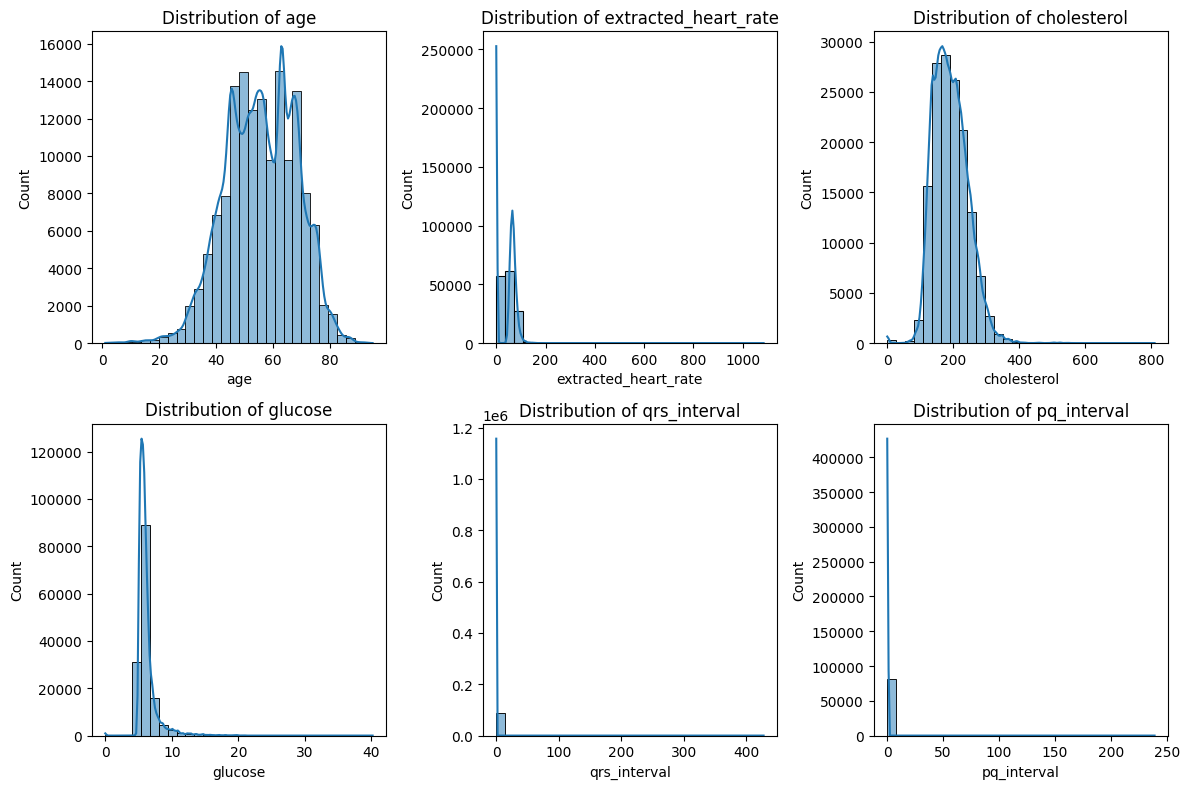

In [26]:
# List of numerical columns to inspect
numerical_columns = ['age', 'extracted_heart_rate', 'cholesterol', 'glucose', 'qrs_interval', 'pq_interval']

# Plotting histograms to visualize the distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  # Create subplots for each numerical column
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()

plt.show()

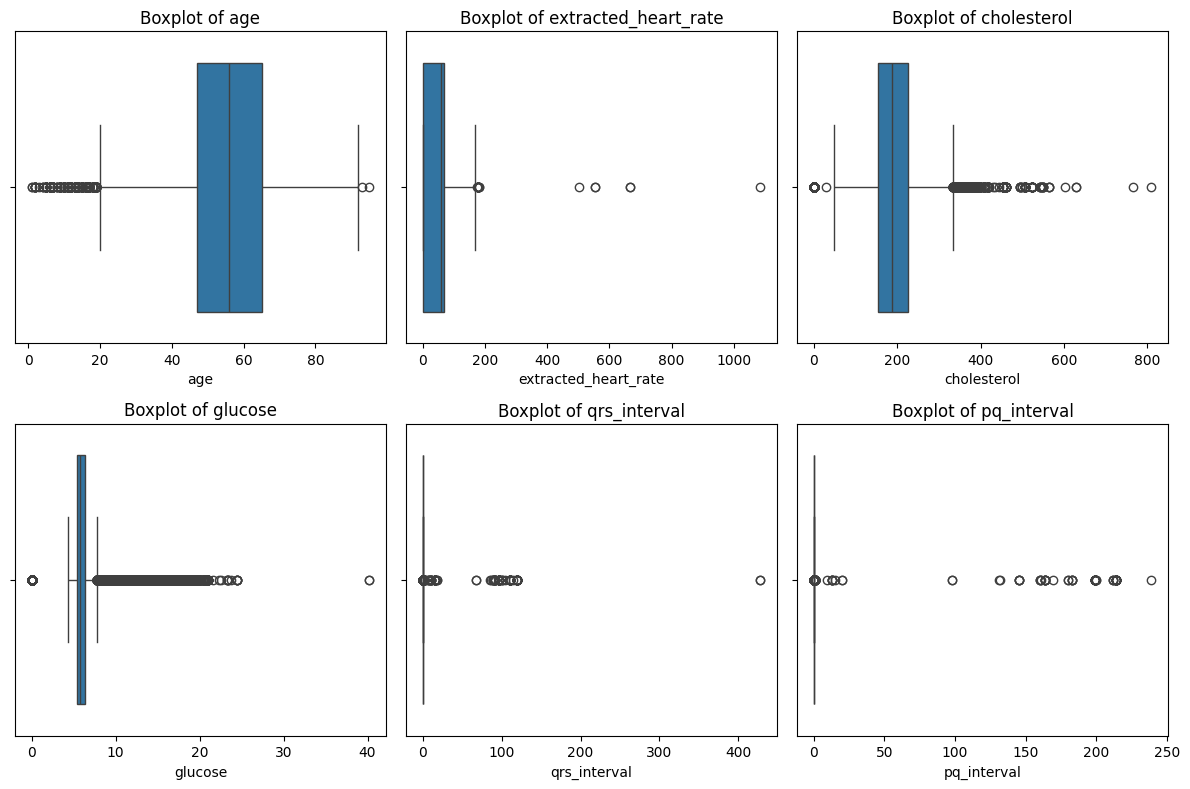

In [27]:
# Box plots to identify potential outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  # Create subplots for each numerical column
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()

plt.show()

In [28]:
# Calculate z-scores for numerical columns
z_scores = df[numerical_columns].apply(zscore)

# Identify rows with z-scores greater than 3 or less than -3 (outliers)
outliers = (z_scores > 3) | (z_scores < -3)

# Display the rows where outliers were detected
outliers_rows = df[outliers.any(axis=1)]
print(outliers_rows)

        patients_id  sex  p_wave_1  p_wave_2  p_wave_3  t_wave_1  t_wave_2  \
480           14367    1       1.0       1.0       1.0       1.0       1.0   
583           36315    1       1.0       1.0       1.0       1.0       1.0   
681            8557    1       1.0       1.0       1.0       1.0       1.0   
1423          14367    1       1.0       1.0       1.0       1.0       1.0   
2046          22088    0       1.0       1.0       1.0       1.0       1.0   
...             ...  ...       ...       ...       ...       ...       ...   
143603       146891    1       1.0       1.0       1.0       1.0       1.0   
143851        61649    1       1.0       1.0       1.0       1.0       1.0   
144539        69452    1       1.0       1.0       1.0       1.0       1.0   
144723        69452    1       1.0       1.0       1.0       1.0       1.0   
145567       226490    0      -2.0      -2.0      -2.0       1.0       1.0   

        t_wave_3  t_wave_4  qrs_interval  ...  glucose choleste

From the boxplots we can observe several potential outliers in the numerical features:

Age:

We see values for age outside of the main range, represented by dots outside the whiskers. These outliers likely correspond to extreme ages (either very young or very old), which might represent unusual or rare cases.
Possible Explanation: These could be incorrect data entries (e.g., a person being listed around 120 years old) or simply rare occurrences (e.g., a patient in an extreme age bracket).

Extracted Heart Rate:

The extracted_heart_rate boxplot has many outliers above 200. This could be due to some patients having very high heart rates recorded in the description and episode columns (i.e., extracted values above the normal physiological range).
Possible Explanation: This might indicate data from patients with tachycardia or a measurement error.

Cholesterol:

The cholesterol boxplot shows a significant number of outliers above 500. The whiskers extend well above the upper quartile, suggesting values are extremely high for some patients.
Possible Explanation: These could represent patients with hypercholesterolemia (high cholesterol) or data errors where cholesterol values were incorrectly recorded.

Glucose:

The glucose boxplot shows outliers in the low range, indicating a significant number of records with very low glucose values (close to or below 0).
Possible Explanation: This could be a data issue where glucose levels were incorrectly entered (e.g., a measurement error). Alternatively, these could indicate patients with severe hypoglycemia.

QRS Interval:

The qrs_interval boxplot has outliers at higher values, indicating long intervals. This could reflect certain abnormal ECG patterns, but could also be data issues.
Possible Explanation: Long QRS intervals may indicate bundle branch blocks or cardiac conduction issues, but outliers might also be due to incorrect data entry.

#### 4. Model Development

#### Imputation

In [30]:
# Impute Missing Numerical Columns with Median (for columns like 'glucose', 'cholesterol', etc.)
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_imputer = SimpleImputer(strategy='median')

# Impute numerical columns
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

# Impute Missing Categorical Columns with Mode
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute categorical columns
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# KNN Imputation for Numerical Columns
# KNN imputation for numerical columns to fill missing or erroneous values based on k-nearest neighbors
knn_imputer = KNNImputer(n_neighbors=5)
df[numerical_columns] = knn_imputer.fit_transform(df[numerical_columns])

# Step 4: Verify the changes
print(df.isnull().sum())


patients_id                    0
sex                            0
p_wave_1                       0
p_wave_2                       0
p_wave_3                       0
t_wave_1                       0
t_wave_2                       0
t_wave_3                       0
t_wave_4                       0
qrs_interval                   0
pq_interval                    0
segment                        0
systole_duration_QRST          0
blood_group                    0
description                    0
episode                        0
glucose                        0
cholesterol                    0
dead                           0
age                            0
extracted_heart_rate           0
rhythm_cleaned                 0
heart_rate                     0
qrs_cleaned                    0
bundle_branch_block_cleaned    0
rhesus_factor_cleaned          0
dtype: int64


In [31]:
df.select_dtypes(include=['object']).columns

Index(['segment', 'description', 'episode', 'rhythm_cleaned'], dtype='object')

In [32]:
df.select_dtypes(include=['number']).columns

Index(['patients_id', 'sex', 'p_wave_1', 'p_wave_2', 'p_wave_3', 't_wave_1',
       't_wave_2', 't_wave_3', 't_wave_4', 'qrs_interval', 'pq_interval',
       'systole_duration_QRST', 'blood_group', 'glucose', 'cholesterol',
       'dead', 'age', 'extracted_heart_rate', 'heart_rate', 'qrs_cleaned',
       'bundle_branch_block_cleaned', 'rhesus_factor_cleaned'],
      dtype='object')

In [33]:
# Count the number of samples in each class
print(df['dead'].value_counts())

# Undersample the majority class (dead = 0)
df_majority = df[df['dead'] == 0]
df_minority = df[df['dead'] == 1]

dead
0.0    145889
1.0       663
Name: count, dtype: int64


In [34]:
# Undersample majority class to match the minority class
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with undersampled majority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Check the new class distribution
print(df_undersampled['dead'].value_counts())

dead
0.0    663
1.0    663
Name: count, dtype: int64


#### Combine numerical and ECG features

In [36]:
# List of numerical columns for model training
numerical_columns = ['age', 'extracted_heart_rate', 'cholesterol', 'glucose', 'blood_group', 'rhesus_factor_cleaned']
                     
# List of ECG features for model training
ecg_features = ['p_wave_1', 'p_wave_2', 'p_wave_3', 't_wave_1', 't_wave_2', 't_wave_3', 't_wave_4', 'qrs_cleaned', 'qrs_interval', 'pq_interval', 'systole_duration_QRST', 'qrs_cleaned', 'bundle_branch_block_cleaned']

# # Combine numerical and ECG features
X = df_undersampled[ecg_features + numerical_columns].values

# List of numerical columns for model training
numerical_columns = ['age', 'extracted_heart_rate', 'cholesterol', 'glucose', 'blood_group', 'rhesus_factor_cleaned']
                     
# List of ECG features for model training
ecg_features = ['p_wave_1', 'p_wave_2', 'p_wave_3', 't_wave_1', 't_wave_2', 't_wave_3', 't_wave_4', 'qrs_cleaned', 'qrs_interval', 'pq_interval', 'systole_duration_QRST', 'qrs_cleaned', 'bundle_branch_block_cleaned']

# # Combine numerical and ECG features
X = df[ecg_features + numerical_columns].values

In [37]:
# Standardize the Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Handle Class Imbalance using SMOTE
y = df_undersampled['dead'].values  # Target variable (binary: 0 for alive, 1 for dead)

y = df['dead'].values  # Target variable (binary: 0 for alive, 1 for dead)

#### Using SMOTE

In [40]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

C:\Users\Nirmal\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Nirmal\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


#### Train-Test Split

In [41]:
# Train-Test Split
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [42]:
# --- Step 5: Model Training ---
# Calculate scale_pos_weight as the ratio of the number of negative samples to positive samples
scale_pos_weight = len(y) / (2 * y.sum())

# XGBoost Model with class weighting
xg_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xg_model.fit(X_train, y_train)

# # XGBoost Model
# xg_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# xg_model.fit(X_train, y_train)

# Define class weights for CatBoost
class_weights = {0: 1, 1: 220}  # Since `dead = 0` is 220 times more frequent than `dead = 1`

# CatBoost Model with class weighting
catboost_model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.05, loss_function='Logloss', class_weights=class_weights, verbose=200)
catboost_model.fit(X_train, y_train)


# # CatBoost Model
# catboost_model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.05, loss_function='Logloss', verbose=200)
# catboost_model.fit(X_train, y_train)

0:	learn: 0.5764203	total: 167ms	remaining: 2m 46s
200:	learn: 0.0108497	total: 1.4s	remaining: 5.56s
400:	learn: 0.0103398	total: 3.26s	remaining: 4.87s
600:	learn: 0.0099828	total: 5.01s	remaining: 3.33s
800:	learn: 0.0094579	total: 6.76s	remaining: 1.68s
999:	learn: 0.0091421	total: 8.51s	remaining: 0us


#### 5. Model Evaluation

In [43]:
# XGBoost Evaluation
y_pred_xg = xg_model.predict(X_test)
y_pred_proba_xg = xg_model.predict_proba(X_test)[:, 1]
print("XGBoost Evaluation:")
print(classification_report(y_test, y_pred_xg))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_xg)}")

# CatBoost Evaluation
y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]
print("CatBoost Evaluation:")
print(classification_report(y_test, y_pred_catboost))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_catboost)}")

XGBoost Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       135
         1.0       1.00      1.00      1.00       131

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266

AUC-ROC: 1.0
CatBoost Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      0.45      0.62       135
         1.0       0.64      1.00      0.78       131

    accuracy                           0.72       266
   macro avg       0.82      0.73      0.70       266
weighted avg       0.82      0.72      0.70       266

AUC-ROC: 0.9787390443878994


#### 6. Results and Discussion

Both XGBoost and CatBoost demonstrated strong performance, achieving high AUC-ROC scores. However, challenges were encountered with the minority class (deceased patients) due to class imbalance.

SMOTE was applied to generate synthetic data for the minority class, balancing the dataset and improving model performance.
Class Weighting was also used to penalize the misclassification of the minority class more heavily, further improving recall for the deceased class.
Despite the improvements, there are still challenges because the dataset needs to be improved

#### 7. Conclusion and Future Work

Conclusion:
XGBoost and CatBoost are effective models for predicting heart disease risk from clinical data.
Techniques such as SMOTE and class weighting helped mitigate class imbalance and improved model performance on the minority class.

Future Work:
Implement more advanced deep learning models like LSTM and CNN for better handling of sequential ECG signal data.
Expand the dataset with more diverse patient data to improve model generalization and real-world applicability.
Integrate real-time ECG monitoring for continuous heart disease detection and improve the model’s practical utility.